# Project 10 - Face Mask Detection

In [1]:
import keras
import tensorflow as tf

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.optimizers import RMSprop
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from keras.metrics import Accuracy

import imutils
import cv2
import numpy as np


## Data Augmentation

In [3]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
import matplotlib as plt

train_datagen=ImageDataGenerator(rotation_range=40, 
                                width_shift_range=.2, 
                                height_shift_range=.2, 
                                shear_range=.2, 
                                zoom_range=.2, 
                                horizontal_flip=True, 
                                fill_mode='nearest')

test_datagen= ImageDataGenerator(rescale=1./255)

In [4]:
# Importing Train data

batch_size=10

train_data=train_datagen.flow_from_directory('C:/Users/Joy/Documents/Project 10/train', 
                                             target_size=(150,150), 
                                             batch_size=batch_size, 
                                             class_mode='binary')

Found 1314 images belonging to 2 classes.


In [5]:
# Importing test data
test_data=test_datagen.flow_from_directory('C:/Users/Joy/Documents/Project 10/test', 
                                           target_size=(150,150),
                                           batch_size=batch_size, 
                                           class_mode='binary')

Found 194 images belonging to 2 classes.


## CNN Model Design

In [6]:
model = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [7]:
# Compiling the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [8]:
# checkpoints to pickout the best trained model with highest accuracy
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',
                             verbose=0,save_best_only=True,mode='auto')

In [9]:
# Train the compiled moddel with data

histroy=model.fit(train_data,
                  steps_per_epoch=50//batch_size,
                  epochs=10,
                  validation_data=test_data,
                  validation_steps=40//batch_size)

Epoch 1/10
5/5 [==============================] - 81s 16s/step - loss: 7.5279 - acc: 0.4600 - val_loss: 7.6664 - val_acc: 0.5250
Epoch 2/10
5/5 [==============================] - 91s 18s/step - loss: 7.6685 - acc: 0.5000 - val_loss: 7.6729 - val_acc: 0.4500
Epoch 3/10
5/5 [==============================] - 90s 18s/step - loss: 7.6703 - acc: 0.4800 - val_loss: 7.6664 - val_acc: 0.5250
Epoch 4/10
5/5 [==============================] - 89s 18s/step - loss: 7.6685 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 5/10
5/5 [==============================] - 83s 17s/step - loss: 7.6580 - acc: 0.6200 - val_loss: 7.6729 - val_acc: 0.4500
Epoch 6/10
5/5 [==============================] - 62s 12s/step - loss: 7.6633 - acc: 0.5600 - val_loss: 7.6663 - val_acc: 0.5250
Epoch 7/10
5/5 [==============================] - 64s 13s/step - loss: 7.6721 - acc: 0.4600 - val_loss: 7.6707 - val_acc: 0.4750
Epoch 8/10
5/5 [==============================] - 63s 13s/step - loss: 7.6668 - acc: 0.5200 - val

# Save the trained model

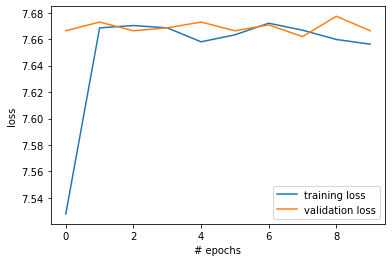

In [14]:
from matplotlib import pyplot as plt

plt.plot(histroy.history['loss'],label='training loss')
plt.plot(histroy.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
# Save the trained model

model.save('detection.h5')

# Loading the model for detection

In [17]:
# import cv2
# import numpy as np
# from keras.models import load_model
# import tensorflow as tf

In [18]:
model = tf.keras.models.load_model('detection.h5')

In [19]:
# result label
results={
    0:'without mask',
    1:'mask'
}

# group dictionary
GR_dict={
    0:(0,0,255),
    1:(0,255,0)
}

# face marking rectangle base size
rect_size = 4

# capturing the video from default system camera
cap = cv2.VideoCapture(0) 

#Object Detection pattern used to identify faces in an image or a real time video feed.
haarcascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [20]:
while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    # press escape key to quit
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()